# **SIADS Milestone II - Forecasting Federal Funds Rate Movements through Natural Language Processing of FOMC Minutes**

**s24-milestone2-team7-cspaarg-cydia-davidrez**
- **Casey Spaargaren(cspaarg@umich.edu)**, School of Information, University of Michigan
- **Cydia Tsang (cydia@umich.edu)**, School of Information, University of Michigan
- **David Rezkalla(davidrez@umich.edu)**, School of Information, University of Michigan


#### **Strcuture of the Code:**

&emsp; **A Data Import**<br>
&emsp;&emsp;&emsp; Federal Reserve's meeting minutes from 1993 to 2024<br>
&emsp; **B. Data Cleaning & Manipulation**<br>
&emsp;&emsp;&emsp; 1.Data Cleaning<br>
&emsp;&emsp;&emsp; 2.Data Manipulation on Meeting Minutes<br>
&emsp;&emsp;&emsp; 3.Data Manipulation on Federal Funds Rate<br>
&emsp;&emsp;&emsp; 4. Data Merge Between MeetingMinutes & Federa Funds Rate<br>
&emsp; **C. NLP Analysis**<br>
&emsp;&emsp;&emsp; 1. Sentiment analysis<br>
&emsp;&emsp;&emsp; 2. Key phrase extraction<br>
&emsp; **D. Supervising Learning**<br>
&emsp;&emsp;&emsp; 1. Naive Bayes, Linear Regression, Support Vector Machine (SVM), and Decision Trees<br>
&emsp;&emsp;&emsp; 2. Random Forest<br>
&emsp;&emsp;&emsp; 3. Gradient Boosting<br>
&emsp;&emsp;&emsp; 4. LSTM (Long Short-Term Memory) Networks:<br>
&emsp;&emsp;&emsp; 5. LLM Model: Bert/ Llama<br>
&emsp; **D Unsupervising Learning**<br>
&emsp;&emsp;&emsp; 1. Topic Modeling (e.g., Latent Dirichlet Allocation - LDA)<br>
&emsp;&emsp;&emsp; 2. Clustering (e.g., K-Means)<br>
&emsp;&emsp;&emsp; 3. Semantic Analysis<br>
&emsp;&emsp;&emsp; 4. LSTM (Long Short-Term Memory) Networks:<br>
&emsp;&emsp;&emsp; 5. Principal Component Analysis (PCA)<br>

In [ ]:
#Remeber to run the following commannd before running the following codes. Details Please refer to README.md
#!pip install -r requirements.txt
#!python -m spacy download en_core_web_sm

In [15]:
from bs4 import BeautifulSoup
import urllib
from time import sleep
import re,csv,os
from os import listdir
from os.path import isfile, join
import os
import glob
import nltk
import pandas as pd
import numpy as np
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from collections import Counter
import string
from textblob import TextBlob
from wordcloud import WordCloud
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

# **A. Data Import**

The project requires the Federal Reserve's meeting minutes from 1993 to 2024, sourced from the official Fed website at https://www.federalreserve.gov. The Federal Open Market Committee (FOMC) holds eight regularly scheduled meetings each year, with additional meetings as needed. Policy statements and minutes are linked in the calendars on the website. The minutes of regularly scheduled meetings are released three weeks after the policy decision date, and committee membership changes occur at the first meeting of each year. The retrieved data is organized and stored as individual files, named meeting_minute_YYYYMMDD.txt, in the data/output directory.

In [96]:
releaseDates = [line.rstrip() for line in open(os.path.join('data/meeting_minute/meeting_dates.csv'), 'r')]

def getFedMeetingMinutesUrl(date):
    year = date[0:4]
    dateInt = int(date)
    if dateInt <= 19951219:
        url = 'https://www.federalreserve.gov/fomc/MINUTES/' + year + '/' + date + 'min.htm'
    elif dateInt >= 19950201 and dateInt < 20070918:
        url = 'https://www.federalreserve.gov/fomc/minutes/' + date + '.htm'
    elif dateInt == 20080625:
        url = 'https://www.federalreserve.gov/monetarypolicy/fomc20080625.htm'
    elif dateInt > 20070918:
        url = 'https://www.federalreserve.gov/monetarypolicy/fomcminutes' + date + '.htm'
    print(url)
    return url

def getStatement(date):
    print('Pulling meeting minute of date: ' + date)
    req = urllib.request.Request(getFedMeetingMinutesUrl(date), headers={'User-Agent' : "Magic Browser"}) 
    html = urllib.request.urlopen( req ).read()
    soup = BeautifulSoup(html)
    minutesText = soup.get_text(" ")
    return minutesText

In [97]:
for releaseDate in releaseDates:
    file_path="./data/output/meeting_minute_" + releaseDate +".txt"
    if os.path.isfile(file_path) == False:
        data = getStatement(releaseDate)
        sleep(2)
    
        f = open(file_path, 'w')
        f.write(data)
        f.close

# **B. Data Cleaning & Manipulation**

This part will extract the raw meeting minutes from data/output directory and do the following data cleaning and manipulation before model training. 
#### **1.Data Cleaning**
The preprocess_text function below is defined to clean the text inside the meeting minutes. This function does the folowi
ng:<br>
- Replaces multiple spaces with a single space<br>
- Removes any punctuation<br>
- Converts the text to lowercase<br>
- Tokenizes the text into individual words<br>
- Removes English stop words (common words like 'is', 'at', 'which', etc.)<br>
- Joins the pre-processed words back ino building.<br>


In [98]:
# Load FOMC meeting minutes
meeting_minutes_dir = "data/output"
meeting_minutes_files = os.listdir(meeting_minutes_dir)

# Function to preprocess text (tokenize and remove stop words)
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    cleaned_tokens = [word for word in filtered_words if word.isalpha()]
    return ' '.join(cleaned_tokens)

meeting_minutes = []
for file in meeting_minutes_files:
    with open(os.path.join(meeting_minutes_dir, file), 'r') as f:
        text = f.read()
        preprocessed_text = preprocess_text(text)
        meeting_minute = {
            'meeting_minute': preprocessed_text,
            'file_date': file.replace('meeting_minute_', '').replace('.txt', '')
        }
        meeting_minutes.append(meeting_minute)

#### **2. Data Manipulation on Meeting Minutes**
- The script below first loads pre-processed meeting minutes data stored in the meeting_minutes variable into a pandas DataFrame and sets the file_date as the index after converting it to a datatime object. The Datarame is then sorted by this index.<br>

In [99]:
meeting_minutes_df = pd.DataFrame(meeting_minutes)
meeting_minutes_df.file_date = pd.to_datetime(meeting_minutes_df.file_date, format='%Y%m%d')
meeting_minutes_df = meeting_minutes_df.set_index('file_date')
meeting_minutes_df = meeting_minutes_df.sort_index()
meeting_minutes_df.head()

,meeting_minute
file_date,
1993-02-03,frb fomc minutesfebruary minutes federal open ...
1993-03-23,frb fomc minutesmarch minutes federal open mar...
1993-05-18,frb fomc minutesmay minutes federal open marke...
1993-07-07,frb fomc minutesjuly minutes federal open mark...
1993-08-17,frb fomc minutesaugust minutes federal open ma...


#### **3. Data Manipulation on Federal Funds Rate**
- Then, the script loads the Federal Funds Rate data from a CSV file into a Dataframe. It converts the data field into a datetime object and renames the value column as rate. A new column diff is created to represent the difference between the current and previous rate values. An additional changed column is created to indicate i the rate remained unchanged ('0') or changed ('1'). Like the meeting minutes DataFrame, the index of this one is set as the date and sort.

In [100]:
# Load Federal Funds Rate data
fed_fund_rate_data = pd.read_csv("data/fed_fund_rate.csv")
fed_fund_rate_data = pd.DataFrame(fed_fund_rate_data)
fed_fund_rate_data['date'] = pd.to_datetime(fed_fund_rate_data['date'])
fed_fund_rate_data = fed_fund_rate_data.rename(columns={'value': 'rate'})
fed_fund_rate_data['diff'] =fed_fund_rate_data['rate'].diff(1)
fed_fund_rate_data['changed'] = np.where(fed_fund_rate_data['diff']!=0.0000, 1, 0)
fed_fund_rate_data = fed_fund_rate_data.set_index('date')
fed_fund_rate_data = fed_fund_rate_data.sort_index()
fed_fund_rate_data.head()

,rate,diff,changed
date,,,
1954-07-07,1.00,NaN,1
1954-07-14,1.22,0.22,1
1954-07-21,0.57,-0.65,1
1954-07-28,0.63,0.06,1
1954-08-04,0.27,-0.36,1


#### **4. Data Merge Between MeetingMinutes & Federa  Funds Rate**
- Finally, the script merges the two data sets based on the nearest date within a tolerance level of seven days. This merger will allow us to associate the meeting minutes to the changes in the Federal Funds rate near the respective meeting date. This data could be used for further analysis o model building.<br>

In [101]:
# Indicate if a rate changed within x days (try 7?) after a document is published, 
# by merging the rate and content df's
# then display what it gets us

tol = pd.Timedelta('7 day')
merge_df = pd.merge_asof(left=meeting_minutes_df,right=fed_fund_rate_data,right_index=True,left_index=True,direction='nearest',tolerance=tol)
merge_df.head()

,meeting_minute,rate,diff,changed
file_date,,,,
1993-02-03,frb fomc minutesfebruary minutes federal open ...,3.15,0.21,1
1993-03-23,frb fomc minutesmarch minutes federal open mar...,2.93,-0.11,1
1993-05-18,frb fomc minutesmay minutes federal open marke...,3.01,0.11,1
1993-07-07,frb fomc minutesjuly minutes federal open mark...,3.10,-0.03,1
1993-08-17,frb fomc minutesaugust minutes federal open ma...,3.06,0.08,1


# **C. NLP Analysis On Meeting Minutes**

### **1. Sentiment analysis**

TextBlob Sentiment Analysis:
- TextBlob libraryis used to compute the sentiment polarity of the given text, returning a value between -1 (very negative) and 1 (very positive).
The sentiment analysis is applied to each entry in the 'meeting_minute' column of the merge_df DataFrame, and the results are stored in a new column called 'sentiment'.

In [102]:
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity  # Returns a value between -1 and 1
    return sentiment

merge_df['sentiment'] = merge_df['meeting_minute'].apply(get_sentiment)

BERT-based Sentiment Analysis:

- The BertTokenizer and BertForSequenceClassification models are loaded from the 'ProsusAI/finbert' pre-trained model. A sentiment analysis pipeline nlp is created with the loaded tokenizer and model. A new get_sentiment(text) function tokenizes the text, truncates it to a maximum length of 512 tokens, and uses the BERT model to predict the sentiment class (negative, neutral, positive). This function is applied to each entry in the 'meeting_minute' column of the merge_df DataFrame, and the results are stored in a new column called 'bert_sentiment'.

In [103]:
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert')

# Create a sentiment analysis pipeline
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Function to get sentiment with text truncation
def get_sentiment(text):
    # Tokenize text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = logits.argmax().item()
    # Map predicted class id to sentiment label
    labels = {0: "negative", 1: "neutral", 2: "positive"}
    return labels[predicted_class_id]

# Apply sentiment analysis to each text in the dataset
merge_df['bert_sentiment'] = merge_df['meeting_minute'].apply(get_sentiment)

The follwoing are the visualizzations of the sentiment analysis results. It creates two subplots: a histogram of the TextBlob sentiment scores with a kernel density estimate (KDE) overlay, and a countplot of the BERT sentiment predictions showing the frequency of each sentiment class. 

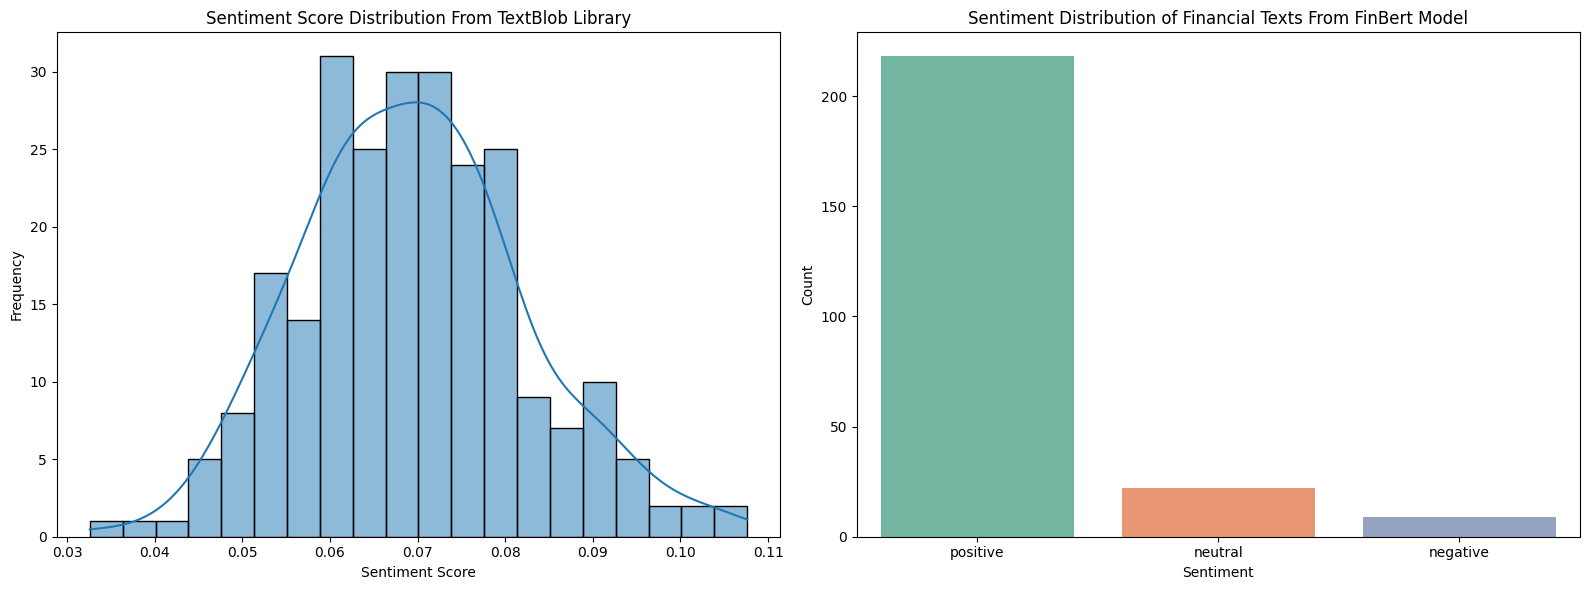

In [104]:
# Sentiment Distribution
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot histogram of sentiment scores
sns.histplot(merge_df['sentiment'], bins=20, kde=True, ax=axes[0], color='#1f77b4')  # Blue color
axes[0].set_title('Sentiment Score Distribution From TextBlob Library')
axes[0].set_xlabel('Sentiment Score')
axes[0].set_ylabel('Frequency')

# Plot countplot of sentiment distribution
sns.countplot(x='bert_sentiment', data=merge_df, hue='bert_sentiment', ax=axes[1], palette='Set2', legend=False)  # Using seaborn palette 'Set2'
axes[1].set_title('Sentiment Distribution of Financial Texts From FinBert Model')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Count')
# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In the first subplot, it plots the sentiment scores from the TextBlob analysis over time with blue markers, setting the y-axis label and tick parameters to match the blue color. It creates a secondary y-axis on the same plot to display the Federal Fund Rate over time with red markers, setting the y-axis label and tick parameters to match the red color.

The second subplot plots the BERT sentiment scores over time with green markers, setting the y-axis label and tick parameters to match the green color.

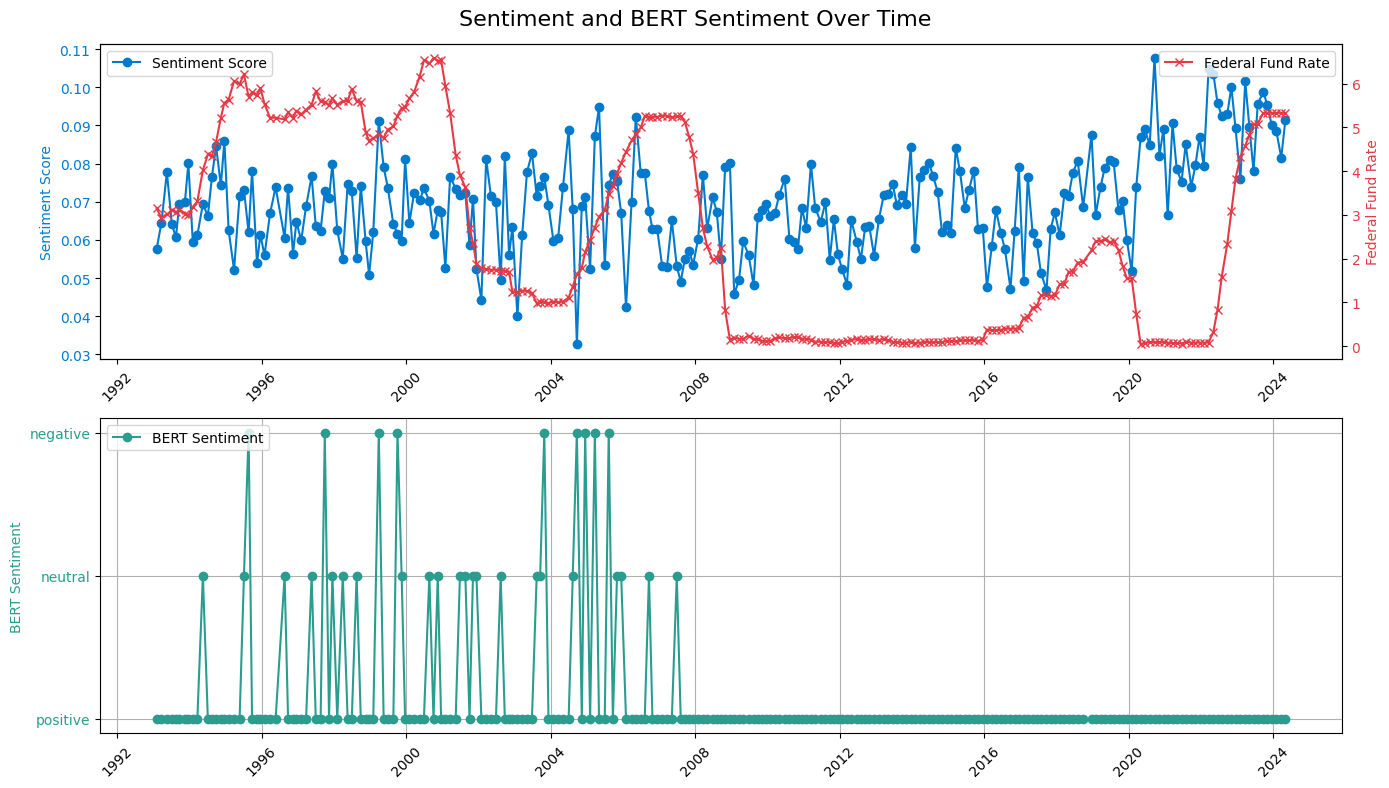

In [105]:
blue_color = '#007ACC'
red_color = '#E63946'
green_color = '#2A9D8F'

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot sentiment and Federal Fund Rate over time
axes[0].plot(merge_df.index, merge_df['sentiment'], color=blue_color, marker='o', label='Sentiment Score')
axes[0].set_ylabel('Sentiment Score', color=blue_color)
axes[0].tick_params(axis='y', labelcolor=blue_color)
axes[0].legend(loc='upper left')

axes_twin = axes[0].twinx()
axes_twin.plot(merge_df.index, merge_df['rate'], color=red_color, marker='x', label='Federal Fund Rate')
axes_twin.set_ylabel('Federal Fund Rate', color=red_color)
axes_twin.tick_params(axis='y', labelcolor=red_color)
axes_twin.legend(loc='upper right')

# Plot BERT Sentiment over time
axes[1].plot(merge_df.index , merge_df['bert_sentiment'], color=green_color, marker='o', label='BERT Sentiment')
axes[1].set_ylabel('BERT Sentiment', color=green_color)
axes[1].tick_params(axis='y', labelcolor=green_color)
axes[1].grid(True)
axes[1].legend(loc='upper left')

# Set common title and x-axis label
plt.suptitle('Sentiment and BERT Sentiment Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)

# Rotate x-axis labels for better readability
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### **2. Key phrase extraction**

The script below uses SpaCy, a library for natural language processing, to find important phrases in meeting minutes. It defines a function that processes a list of texts to identify key phrases, specifically focusing on noun phrases (like "economic growth" or "market trends"). The function ignores common English words and any phrases from a given list of words to exclude, which might not be meaningful in this context.

An exclusion list is created with words and phrases like 'committees', 'participants', and 'economy' that are too general or not useful for the analysis. The function is then applied to the meeting minutes stored in a DataFrame called merge_df. The resulting key phrases for each meeting minute are added as a new column called 'key_phrases'. This helps in highlighting the most relevant and important phrases from the meeting minutes, making it easier to understand the key points discussed.

In [106]:
nlp = spacy.load("en_core_web_sm")

def extract_key_phrases(texts, exclude_strings=None):
    if exclude_strings is None:
        exclude_strings = []
    docs = list(nlp.pipe(texts, batch_size=50))
    key_phrases = []
    for doc in docs:
        phrases = [chunk.text for chunk in doc.noun_chunks if chunk.text.lower() not in stopwords.words('english') and chunk.text.lower() not in exclude_strings]
        key_phrases.append(phrases)
    return key_phrases

exclude_list = ['us', 'committees', 'participants', 'members', 'several participants',
                'committee', 'period', 'term', 'many participants', 'federal reserve banks',
                'federal reserves', 'measures', 'month', 'federal open market committee',
                'member', 'several participant', 'participant', 'many participant',
                'next meeting committee', 'intermeeting period', 'direct federal reserve bank new york',
                'monetary policy', 'office board governor federal reserve system washington dc' ] 
merge_df['key_phrases'] = extract_key_phrases(merge_df['meeting_minute'].tolist(), exclude_strings=exclude_list)


The visualization tracks how often certain key phrases appear each year in the meeting minutes and then creates a plot to show these trends over time. It first counts the key phrases for each year and stores these counts in a table. Then, it makes a graph with two parts: one showing the top key phrases over the years with lines, and another showing the Federal Fund Rate over time with a red line. The result is a clear visual comparison of key phrase trends and interest rates, helping to see how discussion topics and financial policies evolve together.

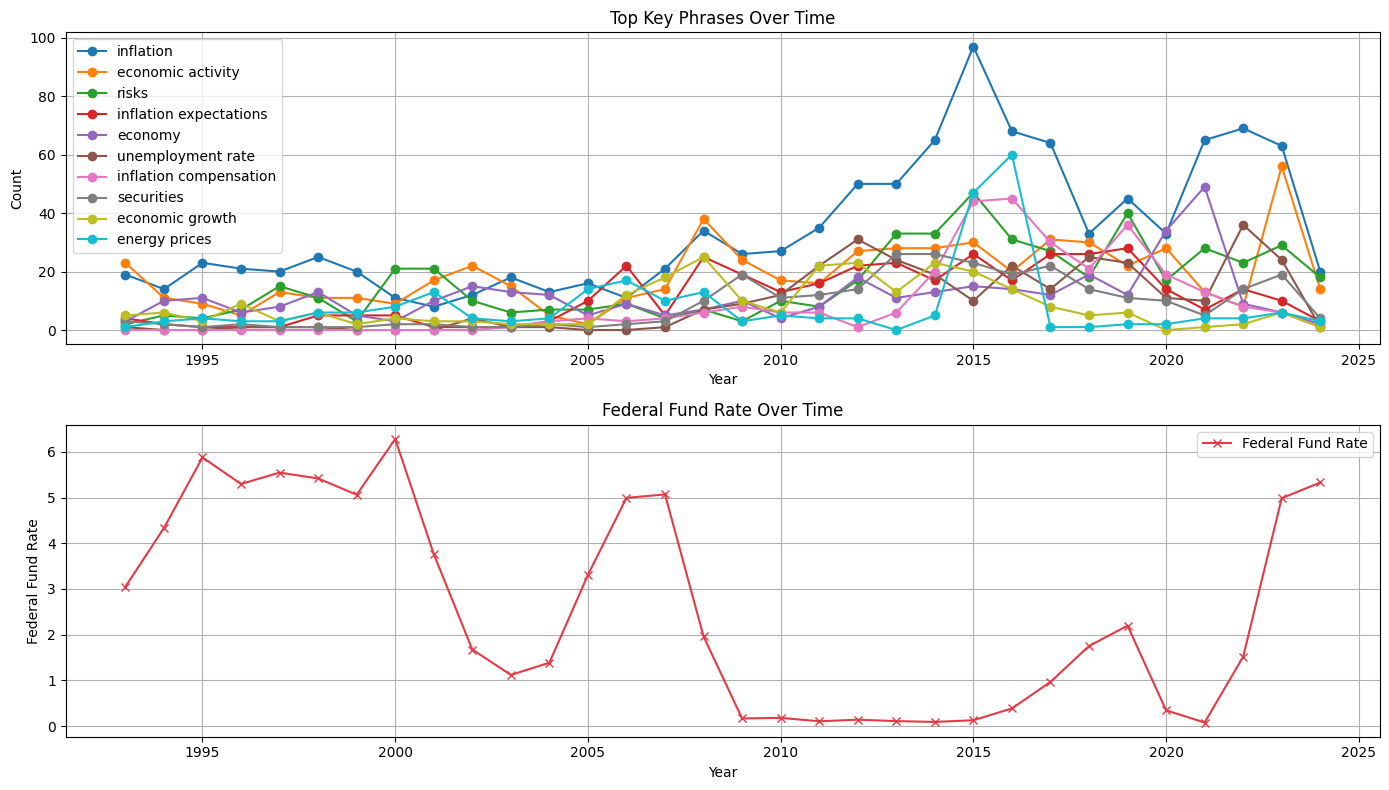

In [107]:
key_phrase_counts = {}

for date, phrases in zip(merge_df.index, merge_df['key_phrases']):
    year = date.year
    if year not in key_phrase_counts:
        key_phrase_counts[year] = Counter()
    key_phrase_counts[year].update(phrases)

# Convert the dictionary to a DataFrame for plotting
key_phrase_df = pd.DataFrame(key_phrase_counts).T.fillna(0)

# Identify the top key phrases (e.g., top 10)
top_phrases = key_phrase_df.sum().sort_values(ascending=False).head(10).index

# Extract year from the index for merging
merge_df['year'] = merge_df.index.year

# Plotting
red_color = '#E63946'
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot the top key phrases over time
for phrase in top_phrases:
    axes[0].plot(key_phrase_df.index, key_phrase_df[phrase], marker='o', label=phrase)

axes[0].set_title('Top Key Phrases Over Time')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Count')
axes[0].legend()
axes[0].grid(True)

# Aggregate the federal funds rate by year (assuming merge_df has 'rate' column)
annual_fed_rate = merge_df.groupby('year')['rate'].mean()

# Plot the federal fund rate over time
axes[1].plot(annual_fed_rate.index, annual_fed_rate, color=red_color, marker='x', label='Federal Fund Rate')
axes[1].set_title('Federal Fund Rate Over Time')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Federal Fund Rate')
axes[1].tick_params(axis='y')
axes[1].legend(loc='upper right')
axes[1].grid(True)

plt.tight_layout()
plt.show()

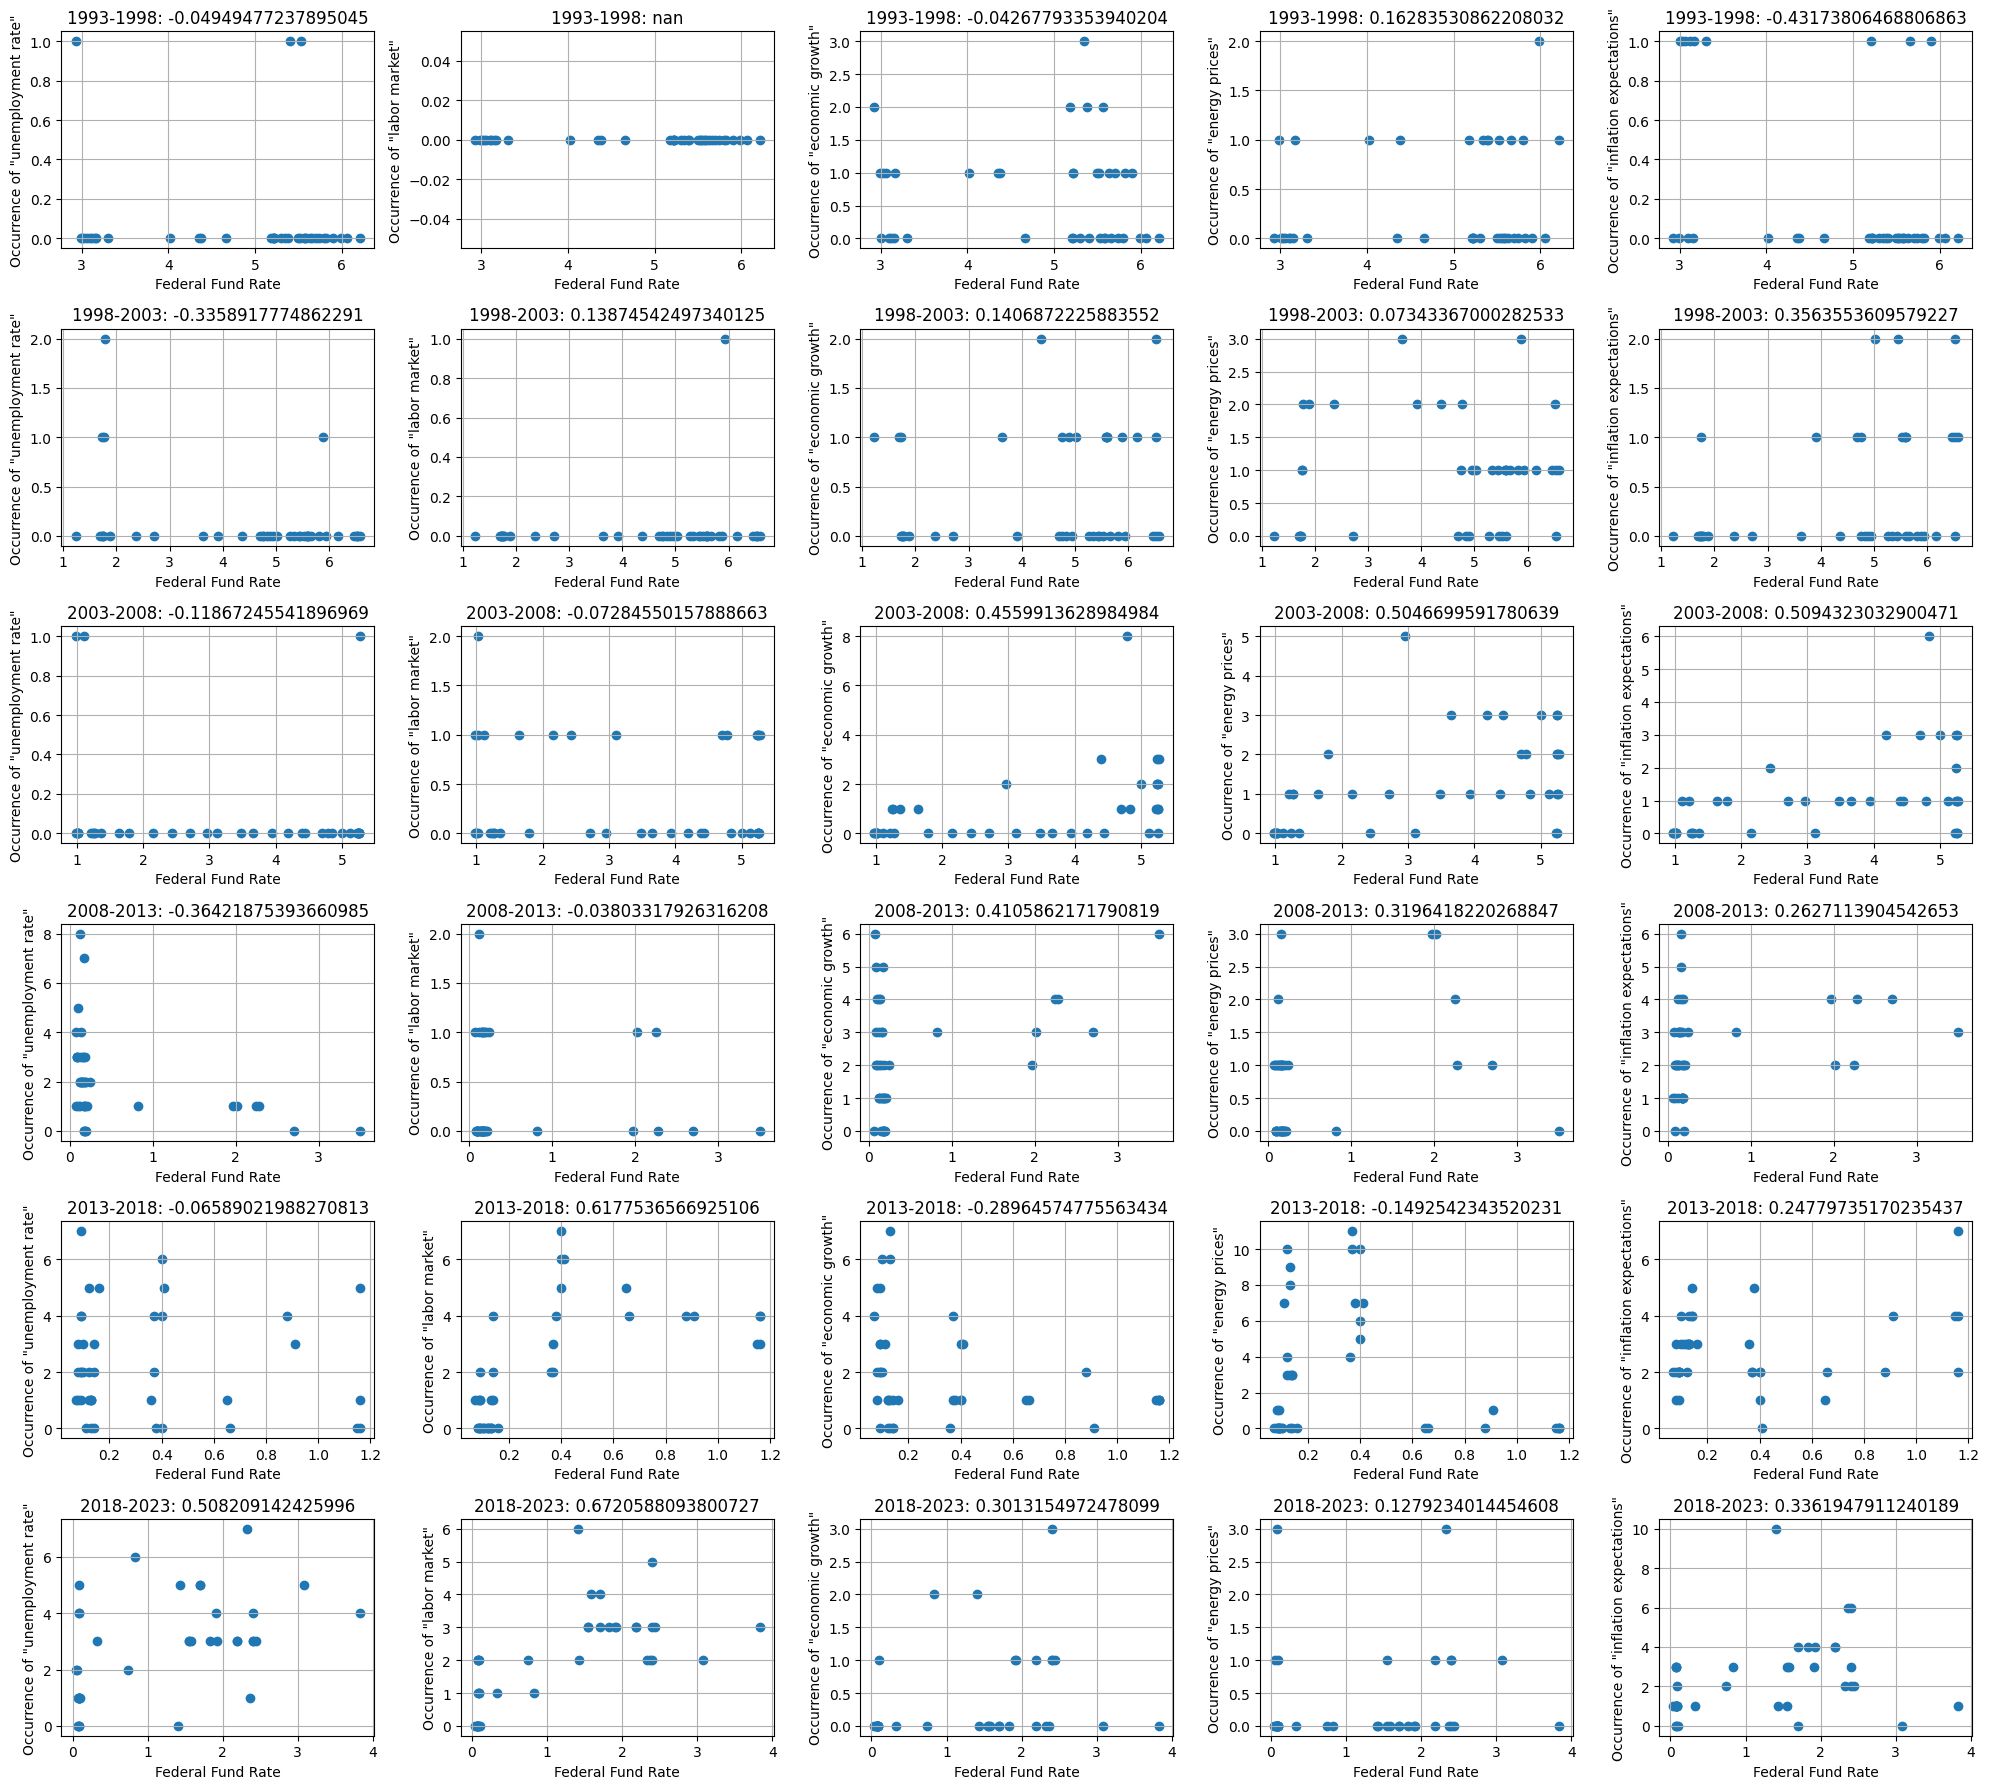

In [123]:
def analyze_5_year_intervals(merge_df, texts):
    # Split the DataFrame into 5-year intervals
    start_year = merge_df.index.year.min()
    end_year = merge_df.index.year.max()
    intervals = range(start_year, end_year + 1, 5)
    
    num_texts = len(texts)
    fig, axes = plt.subplots(len(intervals) - 1, num_texts, figsize=(4 * num_texts,  3 * (len(intervals) - 1)))
    
    for i, (start, end) in enumerate(zip(intervals[:-1], intervals[1:])):
        interval_df = merge_df[(merge_df.index.year >= start) & (merge_df.index.year < end)]
        
        for j, text in enumerate(texts):
            # Calculate the Pearson correlation coefficient for the text
            correlation = interval_df['rate'].corr(interval_df['key_phrases'].apply(lambda x: x.count(text)))

            # Plot the scatter plot for the text
            ax = axes[i, j]
            ax.scatter(interval_df['rate'], interval_df['key_phrases'].apply(lambda x: x.count(text)))
            ax.set_title(f'{start}-{end}: {correlation}')
            ax.set_xlabel('Federal Fund Rate')
            ax.set_ylabel(f'Occurrence of "{text}"')
            ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Perform analysis for each 5-year interval
analyze_5_year_intervals(merge_df, ['unemployment rate', 'labor market', 'economic growth', 'energy prices', 'inflation expectations'])

# **Machine Learning Model**

In [88]:
X = merge_df['meeting_minute'].astype(str)
y = merge_df['rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **D. Supervising Learning** 

Linear Regression:
Mean Squared Error: 0.3224157189102669
R^2 Score: 0.9360203524992671


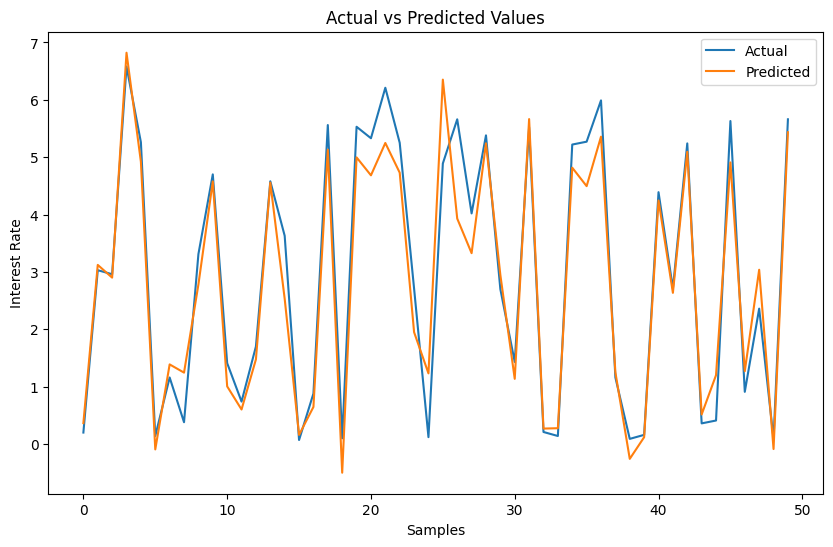


Support Vector Machine (SVM):
Mean Squared Error: 1.3840701660327301
R^2 Score: 0.7253473818263174


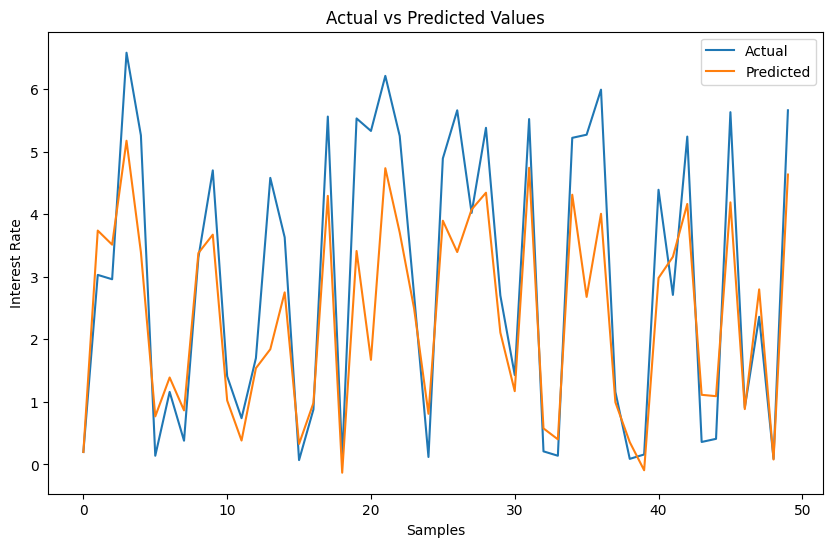


Decision Tree Regressor:
Mean Squared Error: 2.6157960000000005
R^2 Score: 0.4809257235364345


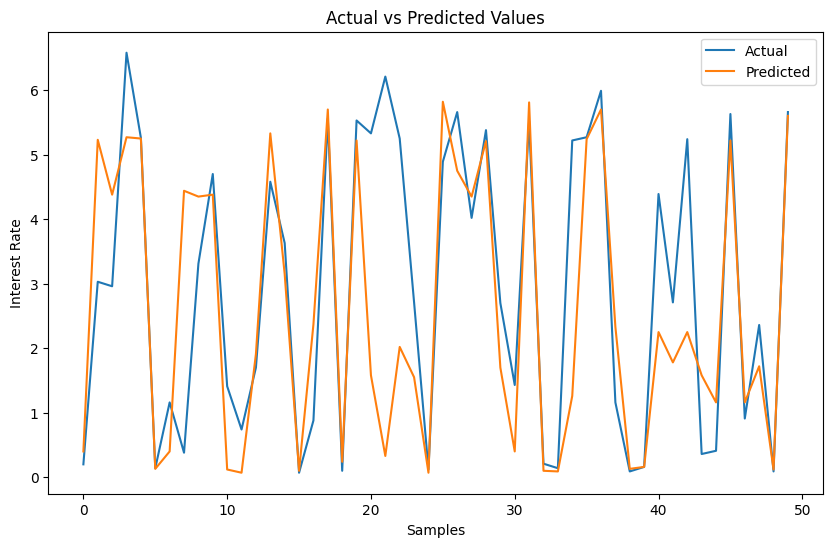

In [89]:
# Linear Regression Pipeline
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('clf', LinearRegression())
])

# Support Vector Machine (SVM) Pipeline
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('clf', SVR(kernel='linear'))
])

# Decision Tree Regressor Pipeline
dt_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('clf', DecisionTreeRegressor(random_state=42))
])

def evaluate_model(pipeline, X_train, X_test, y_train, y_test):
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    
    # Plotting actual vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.legend()
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Samples')
    plt.ylabel('Interest Rate')
    plt.show()
    
    return predictions
    
print("Linear Regression:")
lr_predictions = evaluate_model(lr_pipeline, X_train, X_test, y_train, y_test)

print("\nSupport Vector Machine (SVM):")
svm_predictions = evaluate_model(svm_pipeline, X_train, X_test, y_train, y_test)

print("\nDecision Tree Regressor:")
dt_predictions = evaluate_model(dt_pipeline, X_train, X_test, y_train, y_test)


# TODO : Work on the remaining Supervising Learning or llm model - David

# **E. Unsupervising Learning**

In [ ]:
# TODO : David